In [1]:
from collections import Counter, defaultdict
import itertools
import string
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import pandas as pd


In [2]:
df = pd.read_csv("tsvs/positive_pairs.tsv", sep="\t")
df

,word_a,word_b,rhyme
0,stall,skrall,1
1,ving,ting,1
2,orden,horden,1
3,taler,svaler,1
4,juleskikk,blikk,1
...,...,...,...
7233,spratt,datt,1
7234,brøde,døde,1
7235,gjennomgløder,føder,1
7236,løs,røs,1


In [3]:
pairs = set(zip(*(df.word_a, df.word_b)))
len(pairs)

7238

In [4]:
vocab = set(df.word_a)
vocab.update(set(df.word_b))
len(vocab)

6290

In [5]:
s = "\t".join(vocab)
with open("tsvs/annotation_pairs_vocab.tsv", "w+") as f:
    f.write(s)

## Get buckets from graph
### Connect rhymes via overlapping rhyme pairs
If A and B rhyme, and B and C rhyme, A and C should also rhyme. 
Go through each rhyme pair and create rhyming buckets.

In [6]:
# G = nx.Graph()

# edges = pairs.copy()
# vertices = list(vocab)

# G.add_nodes_from(vertices)
# G.add_edges_from(edges)

# nx.write_edgelist(G, "graphs/rhyme_graph.edgelist")
# buckets = list(nx.connected_components(G))

# with open('pickles/rhyme_graph_buckets.pickle','wb') as f:
#     pickle.dump(buckets, f)

G = nx.read_edgelist("graphs/rhyme_graph.edgelist")
with open('pickles/rhyme_graph_buckets.pickle','rb') as f:
    buckets = pickle.load(f)

In [7]:
len(list(G.edges))

7238

In [8]:
len(buckets), len(pairs)

(1259, 7238)

## Check buckets

In [9]:
not_twos = [bucket for bucket in buckets if len(bucket)>2]
twos = [bucket for bucket in buckets if len(bucket)==2]

print(f"""
There are {len(buckets)} connected components in the graph.
Of these, {len(twos)} are simply isolated rhyme pairs,
meaning {len(buckets) - len(twos)} of the components have more than 2 vertices.
The average number of vertices in the >2 components is {sum(len(bucket) for bucket in not_twos)/len(not_twos)}.
""")


There are 1259 connected components in the graph.
Of these, 727 are simply isolated rhyme pairs,
meaning 532 of the components have more than 2 vertices.
The average number of vertices in the >2 components is 9.090225563909774.



In [10]:
not_twos.sort(key=len, reverse=True)
for i, bucket in enumerate(not_twos):
    print(len(bucket), "\t" , i)
    print(bucket)

227 	 0
{'besværet', 'port', 'ror', 'skapermann', 'Eginafjord', 'hedersmann', 'sjungekor', 'forsann', 'legerot', 'Co.', 'duer', 'ødeland', 'nord', 'truer', 'an', 'fremmedland', 'Tor', 'beherskero', 'fot', 'strand', 'svære', 'kan', 'stort', 'to', 'jord', 'tort', 'motor', 'Bentsebro', 'eie', 'akkord', 'fiskermann', 'skor', 'Nord', 'Sand', 'hvordan', 'flor', 'hårdt', 'kuer', 'forlot', 'tann', 'takke', 'skjæret', 'naglebor', 'næret', 'jo', 'bort', 'overbord', 'leie', 'luer', 'åndehære', 'kristenblod', 'bestemor', 'besnære', 'opveie', 'kongestor', 'stjerneland', 'snor', 'Staats-affære', 'skuer', 'forstand', 'mod', 'vårt', 'hjerteluer', 'perlerand', 'beror', 'kort', 'fro', 'go', 'bære', 'spann', 'Cannes', 'munke-tro', 'hedningjord', 'Ho', 'hor', 'Totakvann', 'overflod', 'blod', 'spor', 'bor', 'hvor', 'rognekjæret', 'bebor', 'mot', 'land', 'ord', 'mor', 'Sillejord', 'slavestand', 'mord', 'lære', 'gro', 'fedreland', 'kirkekor', 'redningsmann', 'fjære', 'han', 'Johan', 'gror', 'glo', 'kjære', '

In [11]:
bad_buckets_i = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 19, 21, 23, 24, 36, 37, 38, 40, 41, 45, 59, 66, 74, 78]

good_buckets = [list(bucket) for i, bucket in enumerate(not_twos) if i not in bad_buckets_i]

under_10 = sum(len(bucket)>10 for bucket in not_twos)


print(f"""
All buckets of len<10 look alright. There are {under_10} buckets of size 2<10.
In addition, {len(good_buckets)} of the larger buckets looked alright.
This means that out of the {len(not_twos)} buckets of size>2, {len(good_buckets)} were good.
{len(bad_buckets_i)} are bad""")


All buckets of len<10 look alright. There are 99 buckets of size 2<10.
In addition, 505 of the larger buckets looked alright.
This means that out of the 532 buckets of size>2, 505 were good.
27 are bad


In [12]:
# Remove a bad word from buckets that shouldn't be there
i_ = 0
j_ = 0
for i, b in enumerate(good_buckets):
    if "smertens-tid" in b:
        i_ = i
    if "hjerter" in b:
        j_ = i
        
good_buckets[i_].remove("smertens-tid")
good_buckets[j_].remove("hjerter")

In [13]:
# with open('pickles/good_buckets.pickle','wb') as f:
#     pickle.dump(good_buckets, f)

with open('pickles/good_buckets.pickle','rb') as f:
    good_buckets = pickle.load(f)
len(good_buckets)

505

In [14]:
tot_words = sum(len(bucket) for bucket in good_buckets)
print(f"""For the {len(good_buckets)} good buckets:
Total words: {tot_words}
% of vocab: {tot_words/len(vocab)*100}
Avg length: {tot_words/len(good_buckets)}
""")

For the 505 good buckets:
Total words: 3326
% of vocab: 52.87758346581876
Avg length: 6.586138613861386



In [15]:
def get_mirrored_dupes(pairs):
    l = list(pairs)
    rem = set()

    for i,(a,b) in enumerate(l):
        if (b,a) in l[i:]:
            rem.add((b, a))
    return rem

In [16]:
gb_pairs = set()

for bucket in good_buckets:
    c = list(itertools.combinations(bucket, 2))
    if c:
        rem = get_mirrored_dupes(c)
        c = set(c) - rem
        gb_pairs.update(c)

In [17]:
len(gb_pairs)

17689

In [18]:
twos = set([tuple(p) for p in twos])

In [19]:
len(twos)

727

In [20]:
len(gb_pairs) + len(twos)

18416

In [21]:
pairs_ = twos.copy()
pairs_.update(gb_pairs)
rem = get_mirrored_dupes(pairs_)
pairs_ -= rem
len(pairs_)

18416

In [22]:
words_a, words_b = zip(*pairs_)
pair_df = pd.DataFrame({"word_a" : words_a , "word_b": words_b, "rhyme": [1]*len(pairs_)})
pair_df.to_csv("tsvs/good_buckets_pairs.tsv", sep="\t", index=False)
pair_df

,word_a,word_b,rhyme
0,stillehavspassat,satt,1
1,stjerneblått,blott,1
2,manne-fall,tempelhall,1
3,store,roret,1
4,fare,mare,1
...,...,...,...
18411,nelde,gjelde,1
18412,bunn,solmorgenstund,1
18413,forpakter,dårefakter,1
18414,finner,hinder,1


In [23]:
orig_pairs = pairs.copy()

In [24]:
print(f"""
All combinations of the good buckets give us {len(gb_pairs)} rhyme pairs.
Of these, {len(gb_pairs)-(len(pairs)-len(orig_pairs))} already existed in the pairs data set.
We increased the pair set by {len(pairs)-len(orig_pairs)}.
+ twos = {len(gb_pairs) + len(twos)}
Vocab = {len(set(list(pair_df.word_a) + list(pair_df.word_b)))}
""")


All combinations of the good buckets give us 17689 rhyme pairs.
Of these, 17689 already existed in the pairs data set.
We increased the pair set by 0.
+ twos = 18416
Vocab = 4780



## HCS !! 
We want to try to cluster = separate the components/buckets on index 1 through 6

from https://github.com/53RT/Highly-Connected-Subgraphs-Clustering-HCS/blob/master/hcs.py

In [25]:
def highly_connected(G, E):
    """Checks if the graph G is highly connected
    Highly connected means, that splitting the graph G into subgraphs needs more than 0.5*|V| edge deletions
    This definition can be found in Section 2 of the publication.
    :param G: Graph G
    :param E: Edges needed for splitting G
    :return: True if G is highly connected, otherwise False
    """

    return len(E) > len(G.nodes) / 2


def remove_edges(G, E):
    """Removes all edges E from G
    Iterates over all edges in E and removes them from G
    :param G: Graph to remove edges from
    :param E: One or multiple Edges
    :return: Graph with edges removed
    """

    for edge in E:
        G.remove_edge(*edge)
    return G


def HCS(G):
    """Basic HCS Algorithm
    cluster labels, removed edges are stored in global variables
    :param G: Input graph
    :return: Either the input Graph if it is highly connected, otherwise a Graph composed of
    Subgraphs that build clusters
    """

    E = nx.algorithms.connectivity.cuts.minimum_edge_cut(G)

    if not highly_connected(G, E):
        G = remove_edges(G, E)
        sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]

        if len(sub_graphs) == 2:
            H = HCS(sub_graphs[0])
            _H = HCS(sub_graphs[1])

            G = nx.compose(H, _H)

    return G

In [26]:
bad_buckets = [not_twos[i] for i in bad_buckets_i]
tot_len = sum(len(b) for b in bad_buckets)

print(f"Total words bad buckets: {tot_len}")
print(f"Avg words bad buckets: {tot_len/len(bad_buckets)}")

Total words bad buckets: 1508
Avg words bad buckets: 55.851851851851855


In [27]:
graphs = []

for gr in bad_buckets:
    edges = set()
    for w1 in gr:
        for w2 in list(G.neighbors(w1)):
            edges.add((w1, w2))
    comp = nx.Graph()
    comp.add_nodes_from(gr)
    comp.add_edges_from(edges)
    graphs.append(comp)

In [28]:
# Uncomment to cluster
# clusters = [HCS(comp.copy()) for comp in graphs]

# for i, cl in enumerate(clusters):
#     print(cl)
#     p = "graphs/cluster"+str(i)+".adjlist"
#     nx.write_adjlist(cl, p)

In [29]:
clusters = [nx.read_adjlist("graphs/cluster"+str(i)+".adjlist") for i in range(len(graphs))]

In [30]:
len(clusters)

27

In [31]:
def get_buckets_and_lost_words(x):
    connected_comps = list(nx.connected_components(x))
    words = [w for comp in connected_comps for w in comp if len(comp)==1]
    buckets = [comp for comp in connected_comps if len(comp)>1]  
    return words, buckets

In [32]:
def get_fig(size):
    if size > 200:
        return plt.figure(figsize=(30, 50))
    if size > 100:
        return plt.figure(figsize=(30, 30))
    if size > 50:
        return plt.figure(figsize=(20, 20))
    return plt.figure(figsize=(10, 10))
    

In [33]:
more_buckets = []
lost_words = 0
not_divided = 0

for i, (graph, cluster) in enumerate(zip(graphs, clusters)):
    size = len(graph.nodes)
    words_, buckets_ = get_buckets_and_lost_words(cluster)    
    f = get_fig(size)
    nx.draw(graph, ax=f.add_subplot(111), with_labels=True)
    f.savefig(f"figs/pre_clustering_graph_{i}.png")
    plt.close(f)

    
    if len(buckets_) == 1:
        not_divided += 1
        print(f"Graph {i} was not separated.\n")
        continue
    print(f"""Graph {i} was separated into {len(buckets_)} components.
    It originally had {size} vertices.
    Now it has {size - len(words_)}.
    This means {len(words_)} words were separated into single vertex clusters.
    """)
    f = get_fig(size)
    nx.draw(nx.restricted_view(cluster, edges=[], nodes=(words_)), ax=f.add_subplot(111),  with_labels=True)
    f.savefig(f"figs/post_clustering_graph_{i}.png")
    plt.close(f)

    
    more_buckets += buckets_
    lost_words += len(words_)

Graph 0 was separated into 8 components.
    It originally had 227 vertices.
    Now it has 50.
    This means 177 words were separated into single vertex clusters.
    
Graph 1 was separated into 8 components.
    It originally had 189 vertices.
    Now it has 38.
    This means 151 words were separated into single vertex clusters.
    
Graph 2 was separated into 5 components.
    It originally had 148 vertices.
    Now it has 23.
    This means 125 words were separated into single vertex clusters.
    
Graph 3 was separated into 5 components.
    It originally had 144 vertices.
    Now it has 38.
    This means 106 words were separated into single vertex clusters.
    
Graph 4 was separated into 3 components.
    It originally had 92 vertices.
    Now it has 16.
    This means 76 words were separated into single vertex clusters.
    
Graph 5 was separated into 3 components.
    It originally had 68 vertices.
    Now it has 11.
    This means 57 words were separated into single vertex

In [34]:
len(more_buckets), not_divided

(70, 6)

In [35]:
tot_words = sum(len(bucket) for bucket in more_buckets)
print(f"""For the {len(more_buckets)} more buckets:
Total words: {tot_words}
% of vocab: {tot_words/len(vocab)*100}
Avg length: {tot_words/len(more_buckets)}
""")

For the 70 more buckets:
Total words: 336
% of vocab: 5.34181240063593
Avg length: 4.8



In [36]:
more_buckets = [list(b) for b in more_buckets]

In [37]:
# with open('pickles/hcs_rhyme_graph_buckets.pickle','wb') as f:
#     pickle.dump(more_buckets, f)

with open('pickles/hcs_rhyme_graph_buckets.pickle','rb') as f:
    more_buckets = pickle.load(f)

In [38]:
more_vocab = sum([len(bucket) for bucket in more_buckets])

print(f"""
With the buckets we got from graph clustering we got
{len(more_buckets)} new buckets
Average size: {more_vocab/len(more_buckets)}
{more_vocab} words out of {len(vocab)} total
We lost {lost_words} vertices
Of the bad buckets, {not_divided} were not divided by HCS
""")



With the buckets we got from graph clustering we got
70 new buckets
Average size: 4.8
336 words out of 6290 total
We lost 1055 vertices
Of the bad buckets, 6 were not divided by HCS



## Create rhyme pairs from more_buckets

In [39]:
graph_pairs = set()

for bucket in more_buckets:
    c = list(itertools.combinations(bucket, 2))
    if c:
        rem = get_mirrored_dupes(c)
        c = set(c) - rem
        graph_pairs.update(c)
len(graph_pairs)

787

In [40]:
new_pairs = graph_pairs - orig_pairs

In [41]:
pairs1 = pairs_.copy()
pairs1.update(graph_pairs)
len(pairs1)

19203

In [42]:
print(f"""
All combinations of the more_buckets give us {len(graph_pairs)} rhyme pairs.
Of these, {len(graph_pairs.intersection(orig_pairs))} already existed in the pairs data set.
We increased the pair set by {len(new_pairs)}.

However, the original pairs data set contain bad edges.
We add the {len(pairs_)} good_buckets pairs and {len(graph_pairs)} more_buckets pairs together for a new pair dataset.
The total length is {len(pairs1)}
""")


All combinations of the more_buckets give us 787 rhyme pairs.
Of these, 338 already existed in the pairs data set.
We increased the pair set by 449.

However, the original pairs data set contain bad edges.
We add the 18416 good_buckets pairs and 787 more_buckets pairs together for a new pair dataset.
The total length is 19203



In [88]:
words_a, words_b = zip(*pairs1)
pair_df = pd.DataFrame({"word_a" : words_a, "word_b": words_b, "rhyme": [1]*len(pairs1)})
pair_df.to_csv("tsvs/hcs_plus_good_buckets_pairs.tsv", sep="\t", index=False)

In [89]:
pair_df

,word_a,word_b,rhyme
0,stillehavspassat,satt,1
1,stjerneblått,blott,1
2,med,ned,1
3,manne-fall,tempelhall,1
4,store,roret,1
...,...,...,...
19198,nelde,gjelde,1
19199,bunn,solmorgenstund,1
19200,forpakter,dårefakter,1
19201,finner,hinder,1


In [91]:
v = set(list(pair_df.word_a)+list(pair_df.word_b))
len(v)

5116

## Manually remove bad edges

ord som den  
men/mén  
seg/seg  
brød dø, nød  
råd få, dåd  
morgen sorgen, våren  

In [45]:
manual_buckets = []
all_bad_edges = []

In [46]:
len(graphs)

27

Graph 26 was separated into 2 components.
It originally had 13 vertices.
Now it has 13.



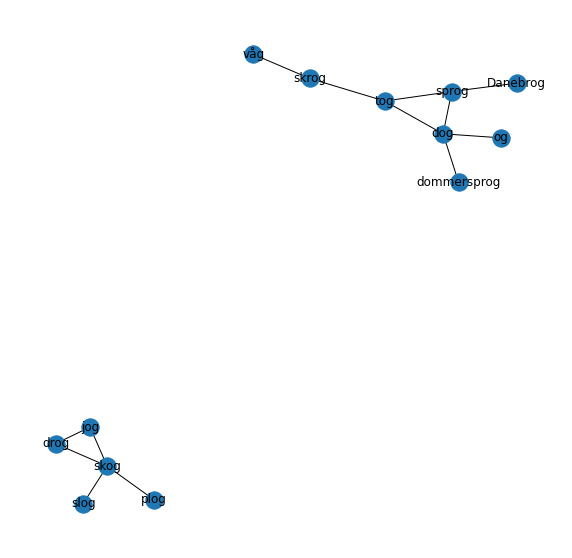

In [47]:
i = 26
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()
            
for e in [("tog", "slog")]:
    g.remove_edge(*e)

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 25 was separated into 2 components.
It originally had 13 vertices.
Now it has 13.



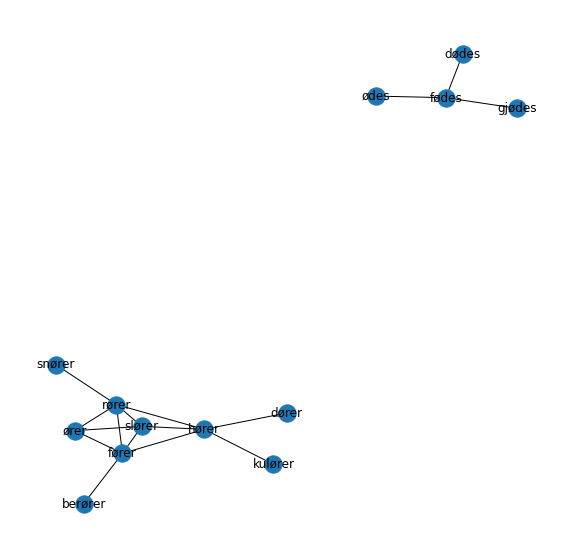

In [48]:
i = 25
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("rører", "fødes")]

for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 24 was separated into 2 components.
It originally had 14 vertices.
Now it has 14.



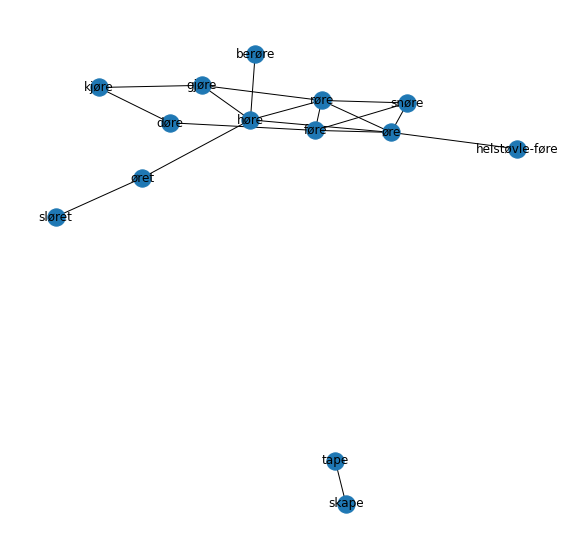

In [49]:
i = 24
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("øret", "skape")]

for e in bad_edges:
    g.remove_edge(*e)
    
all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 23 was separated into 3 components.
It originally had 15 vertices.
Now it has 15.



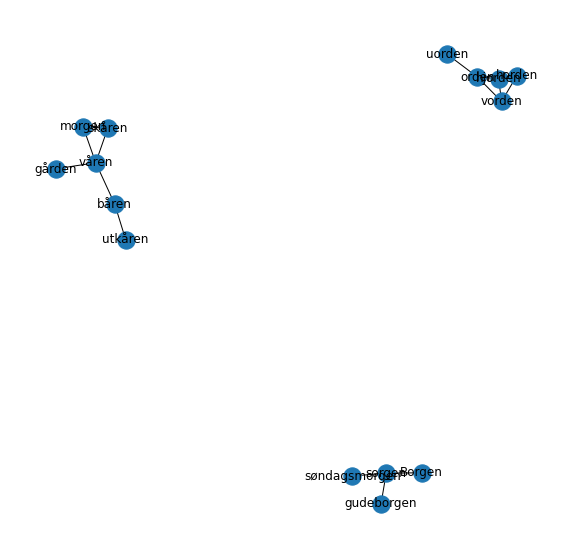

In [50]:
i = 23
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


for e in [("gården", "orden"), ("gården", "uorden"), ("morgen", "Borgen"), 
          ("gudeborgen", "morgen"), ("sorgen", "morgen")]:
    g.remove_edge(*e)

g.add_edge("gudeborgen", "sorgen")
g.add_edge("Borgen", "sorgen")
g.add_edge("uorden", "orden")

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 22 was separated into 3 components.
It originally had 18 vertices.
Now it has 18.



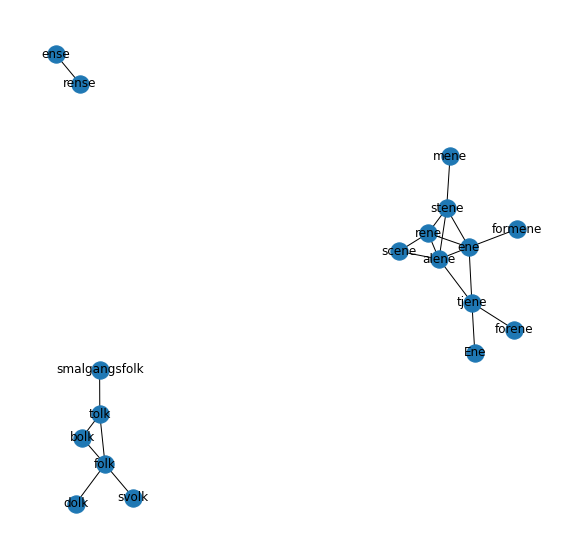

In [51]:
i = 22
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


bad_edges = [("tolk", "tjene"), ("folk", "ene"), ("stene", "ense")]
    
for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 21 was separated into 2 components.
It originally had 19 vertices.
Now it has 19.



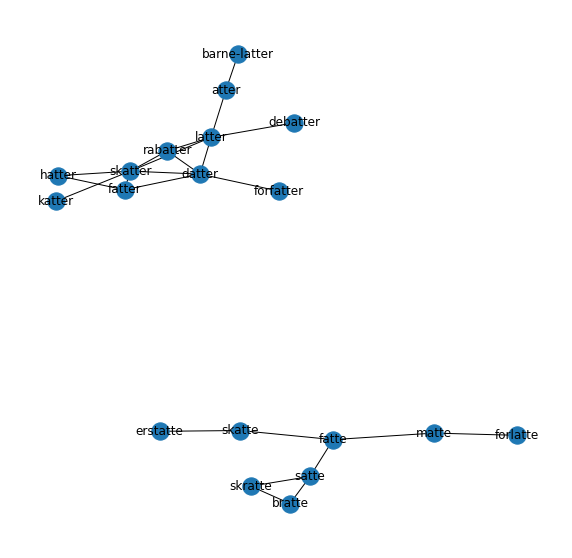

In [52]:
i = 21
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


bad_edges = [("bratte", "hatter"), ("bratte", "fatter"), ("bratte", "skatter")]
    
for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 20 was separated into 2 components.
It originally had 19 vertices.
Now it has 19.



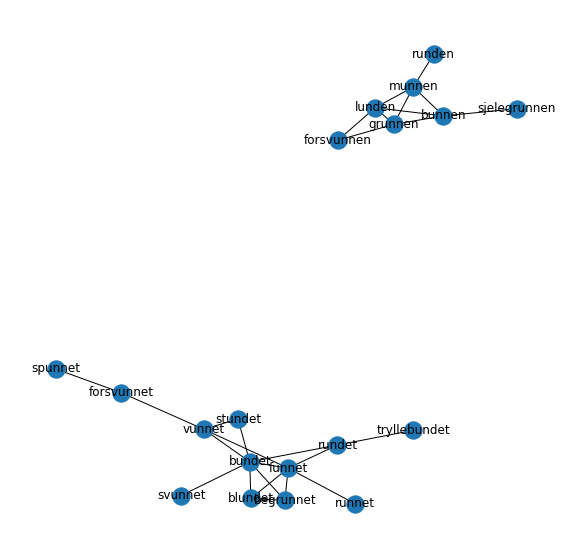

In [53]:
i = 20
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("vunnet", "grunnen")]

for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 19 was separated into 2 components.
It originally had 20 vertices.
Now it has 20.



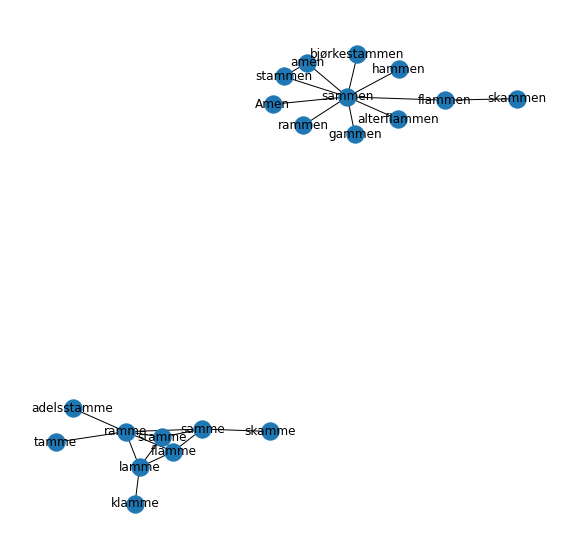

In [54]:
i = 19
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("Amen", "ramme"), ("sammen", "tamme"), ("sammen", "ramme"), ("tamme", "Amen")]

for e in bad_edges:
    g.remove_edge(*e)
    
all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 18 was separated into 2 components.
It originally had 21 vertices.
Now it has 21.



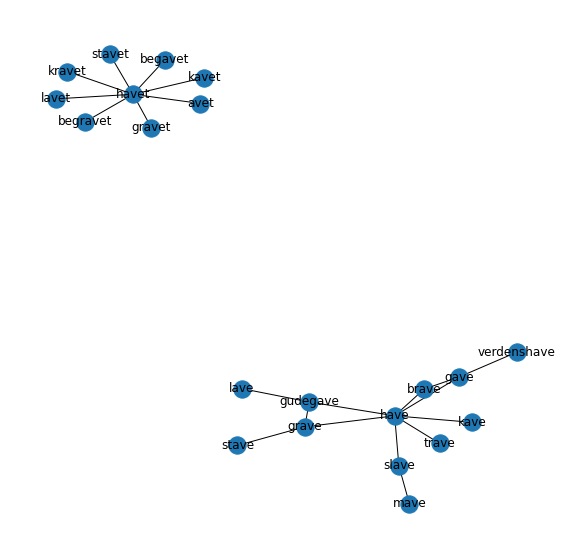

In [55]:
i = 18
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


bad_edges = [("gave", "havet"), ("kave", "havet")]

for e in bad_edges:
    g.remove_edge(*e)
    
all_bad_edges += bad_edges

g.add_edge("kave", "have")    

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 17 was separated into 2 components.
It originally had 21 vertices.
Now it has 21.



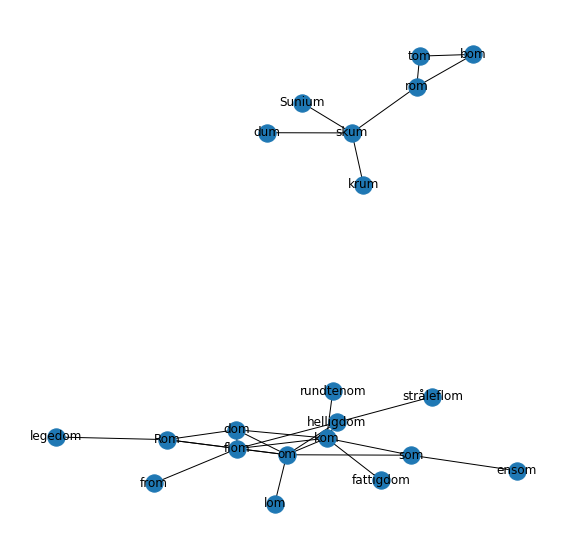

In [56]:
i = 17
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("bom", "dom"), ("rom", "om"), ("bom", "om")]    

for e in bad_edges + [("dom", "tom"), ("om", "tom"), ("kom", "tom"), ("rundtenom", "tom")]:
    g.remove_edge(*e)
    
all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
#f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 16 was separated into 2 components.
It originally had 27 vertices.
Now it has 27.



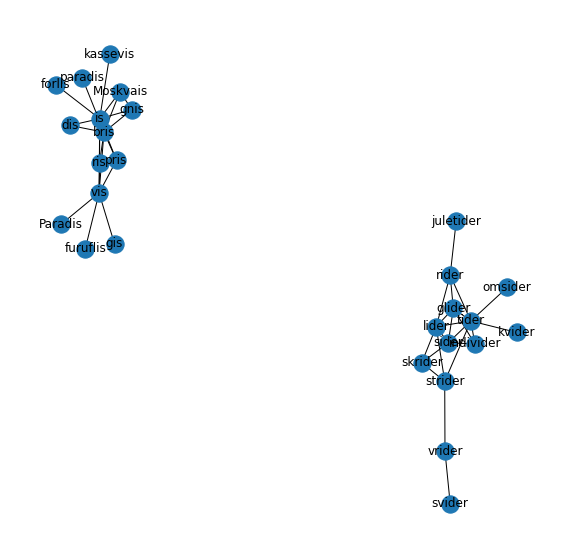

In [57]:
i = 16
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("pris", "lider"), ("vis", "lider")]

for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 15 was separated into 2 components.
It originally had 28 vertices.
Now it has 28.



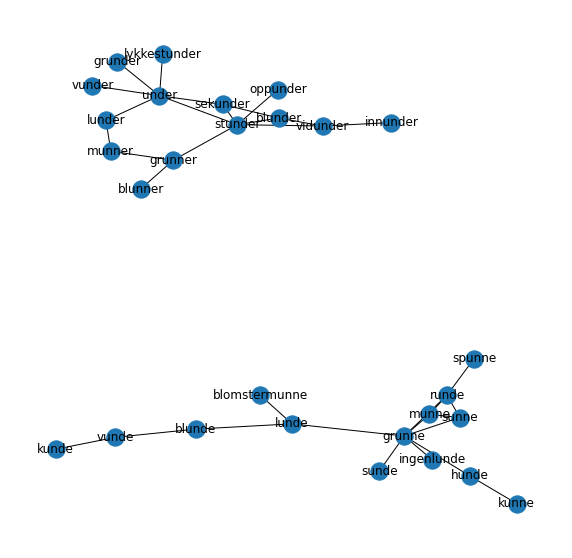

In [58]:
i = 15
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("munner", "grunne"), ("munner", "lunde"), ("munner", "blunde")]

for e in bad_edges:
    g.remove_edge(*e)
    
all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 14 was separated into 2 components.
It originally had 29 vertices.
Now it has 28.



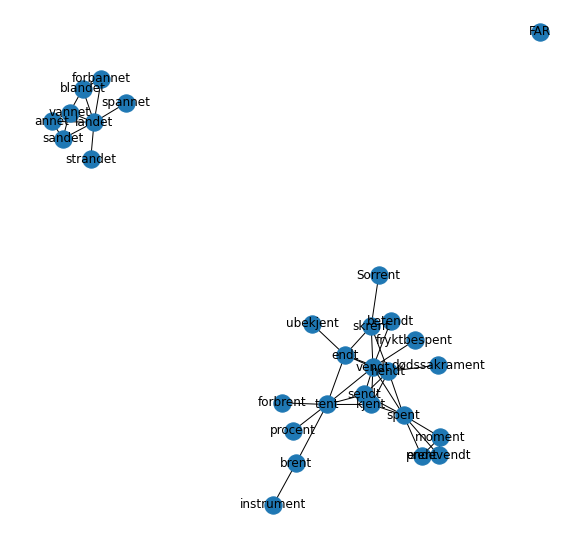

In [59]:
i = 14
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("forbannet", "tent"), ("forbrent", "landet"), ("FAR", "landet"), ("FAR", "annet")]
for e in bad_edges:
    g.remove_edge(*e)
    
g.add_edge("forbrent", "tent")
    
all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
 
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 13 was separated into 2 components.
It originally had 29 vertices.
Now it has 29.



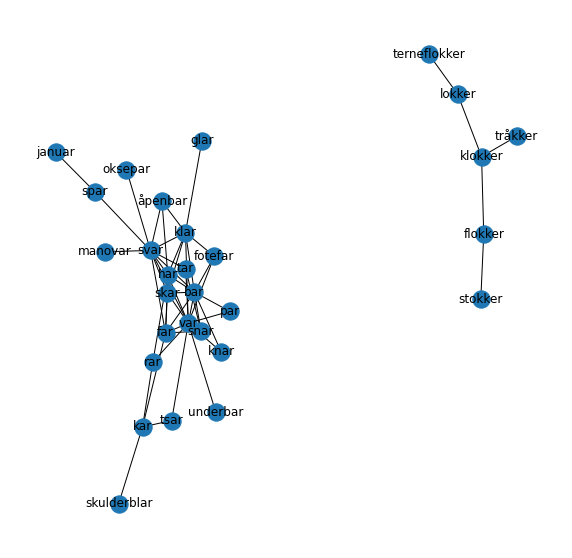

In [60]:
i = 13
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("klokker", "tar"), ("lokker", "svar")] 

for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 12 was separated into 4 components.
It originally had 38 vertices.
Now it has 38.



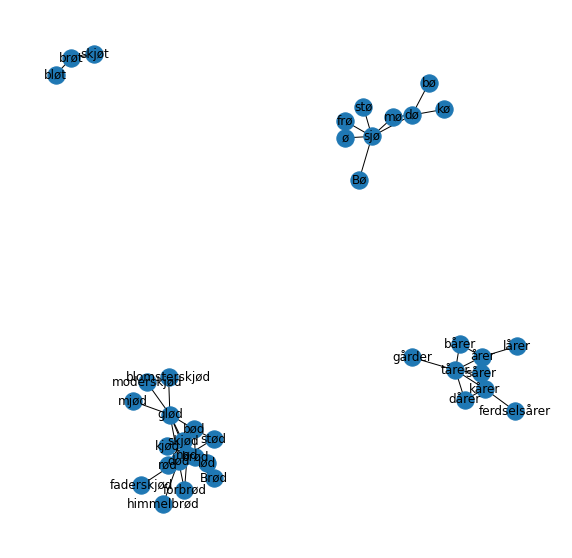

In [61]:
i = 12
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [
    # straight up wrong
    ("skjød", "bårer"), ("skjød", "tårer"),
    
    # phonetically similar
    ("glød", "brøt"),
]

for e in bad_edges + [("brød", "dø")]:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 11 was separated into 2 components.
It originally had 39 vertices.
Now it has 39.



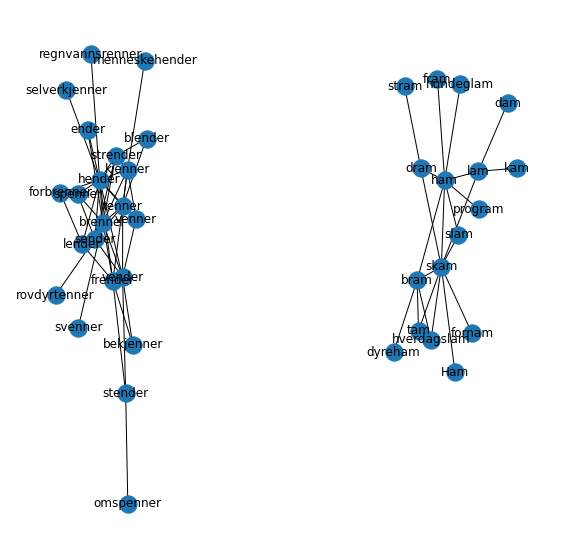

In [62]:
i = 11
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("ham", "sender"), ("ham", "hender")]

for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 10 was separated into 3 components.
It originally had 45 vertices.
Now it has 45.



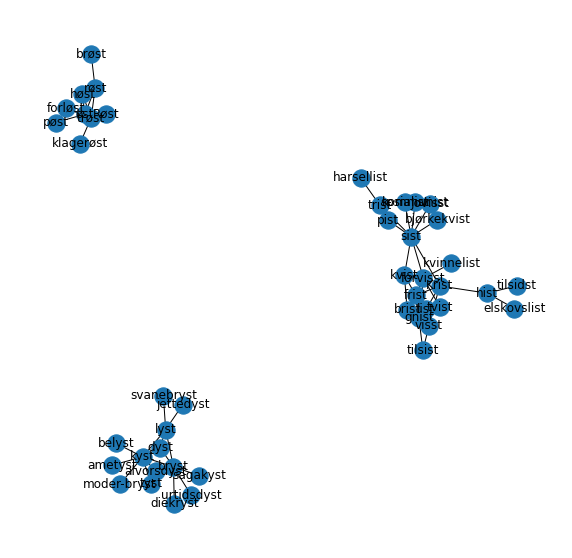

In [63]:
i = 10
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("sist", "kyst"), ("bryst", "høst")]
for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 9 was separated into 3 components.
It originally had 45 vertices.
Now it has 45.



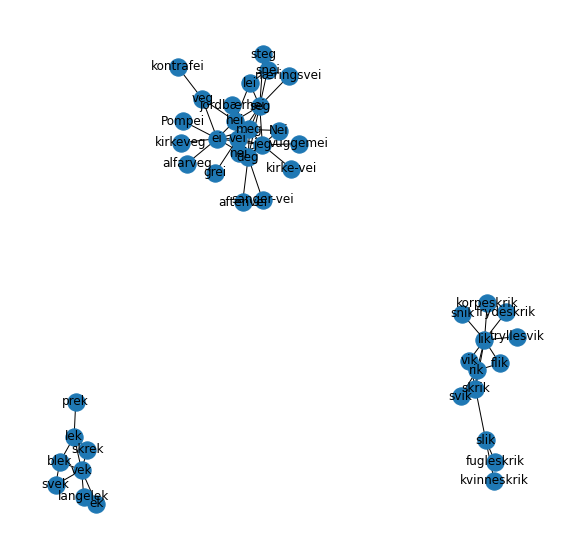

In [64]:
i = 9
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("steg", "lek"), ("seg", "lik")]

for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 8 was separated into 2 components.
It originally had 58 vertices.
Now it has 58.



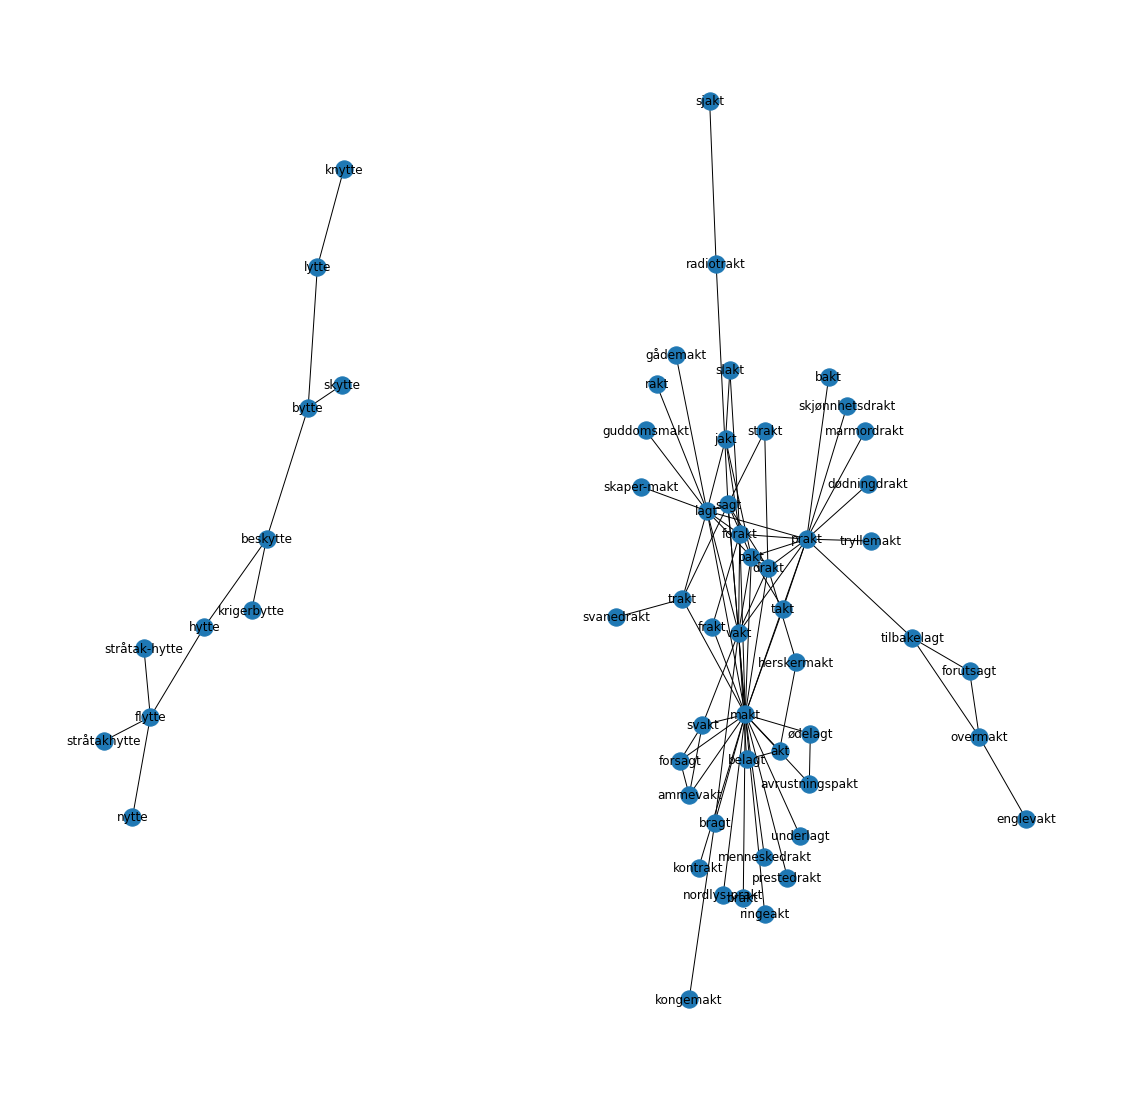

In [65]:
i = 8
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [("hytte", "makt"), ("beskytte", "prakt")]

for e in bad_edges:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 7 was separated into 3 components.
It originally had 62 vertices.
Now it has 62.



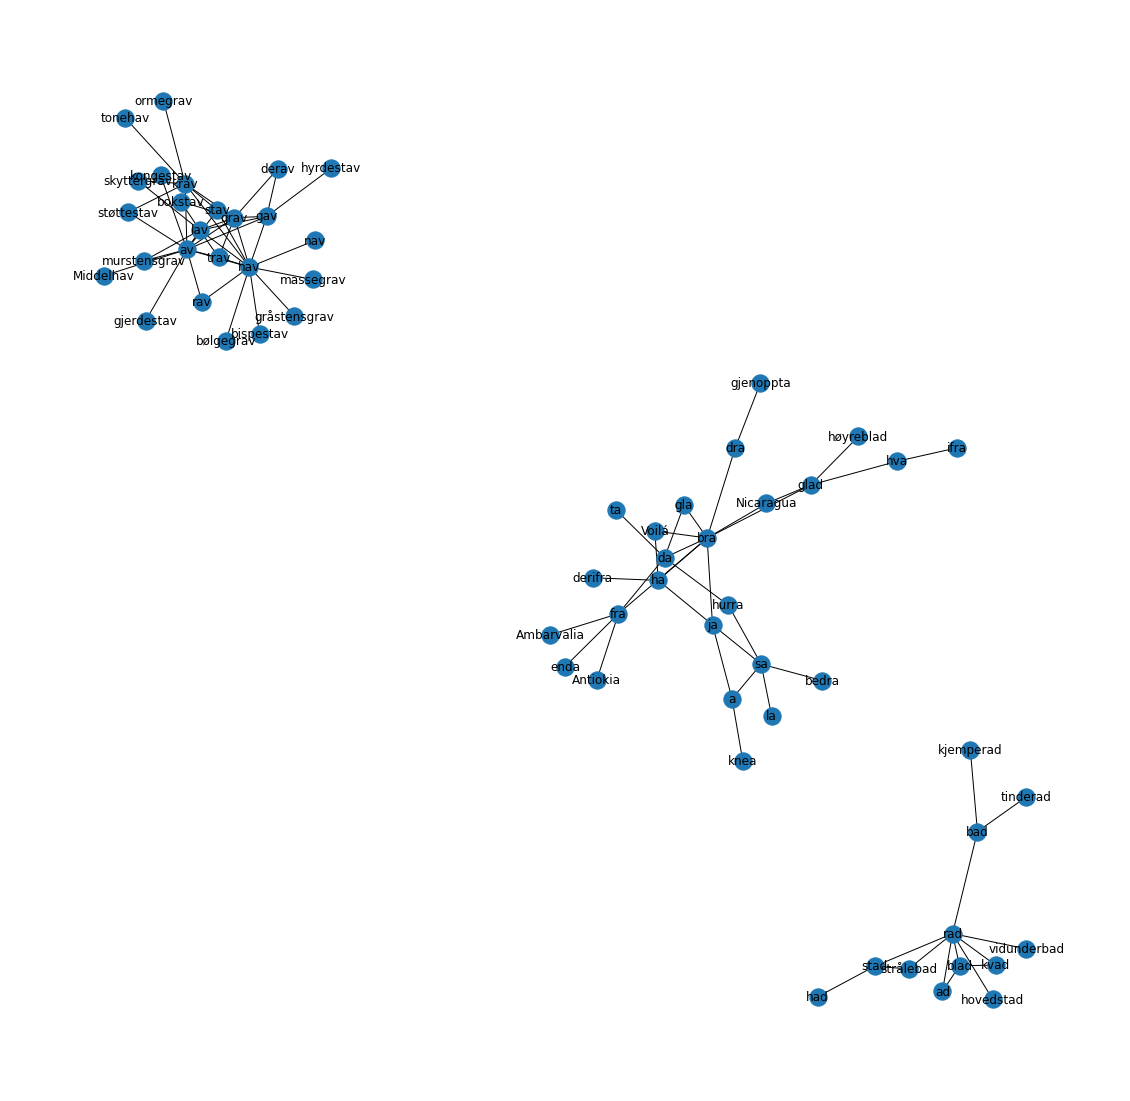

In [66]:
i = 7
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

            # pronunciation variation
for e in [("sa", "av"), ("ifra", "blad"), ("hva", "glad"), ("glad", "ad"), ("glad", "strålebad"), ("glad", "bad"), 
("glad", "vidunderbad"), ("glad", "stad"), ("glad", "rad")]:
    g.remove_edge(*e)

g.add_edge("hva", "glad")
g.add_edge("ifra", "hva")
g.add_edge("vidunderbad", "rad")
    
words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 6 was separated into 5 components.
It originally had 67 vertices.
Now it has 65.



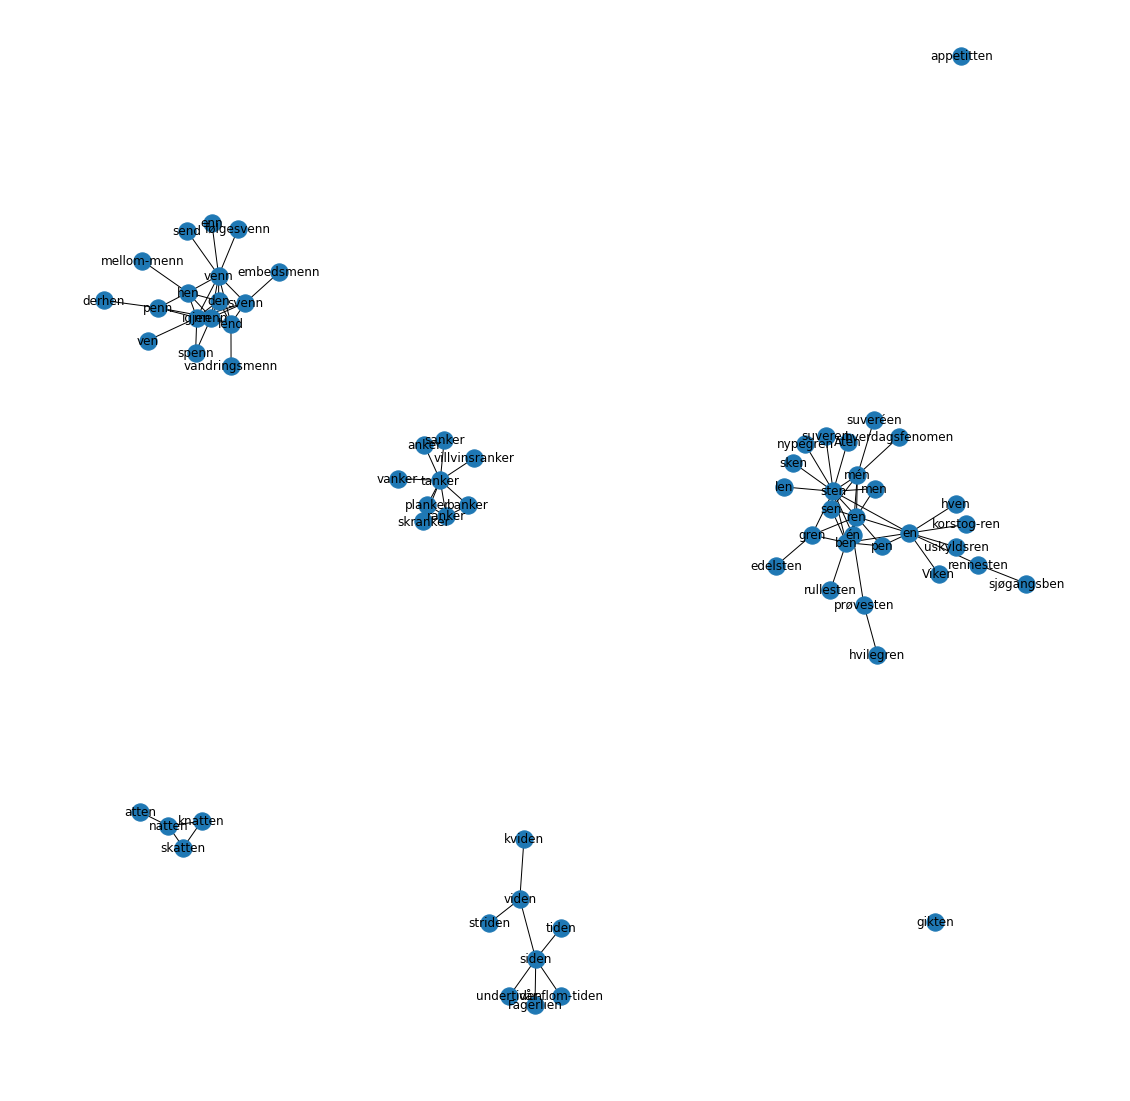

In [67]:
i = 6
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [
    # straight up wrong
    ("ranker", "venn"), ("tanker", "ben"), ("én", "anker"), ("tanker", "menn"),
]
                       #phonetical variation
for e in bad_edges + [("en", "lend"), ("men", "menn"), ("den", "men"),
                      # rhyme spanning several words
                   ("natten", "den"), ("tiden", "den"), ("appetitten", "den"), ("gikten", "den")]:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 5 was separated into 4 components.
It originally had 68 vertices.
Now it has 67.



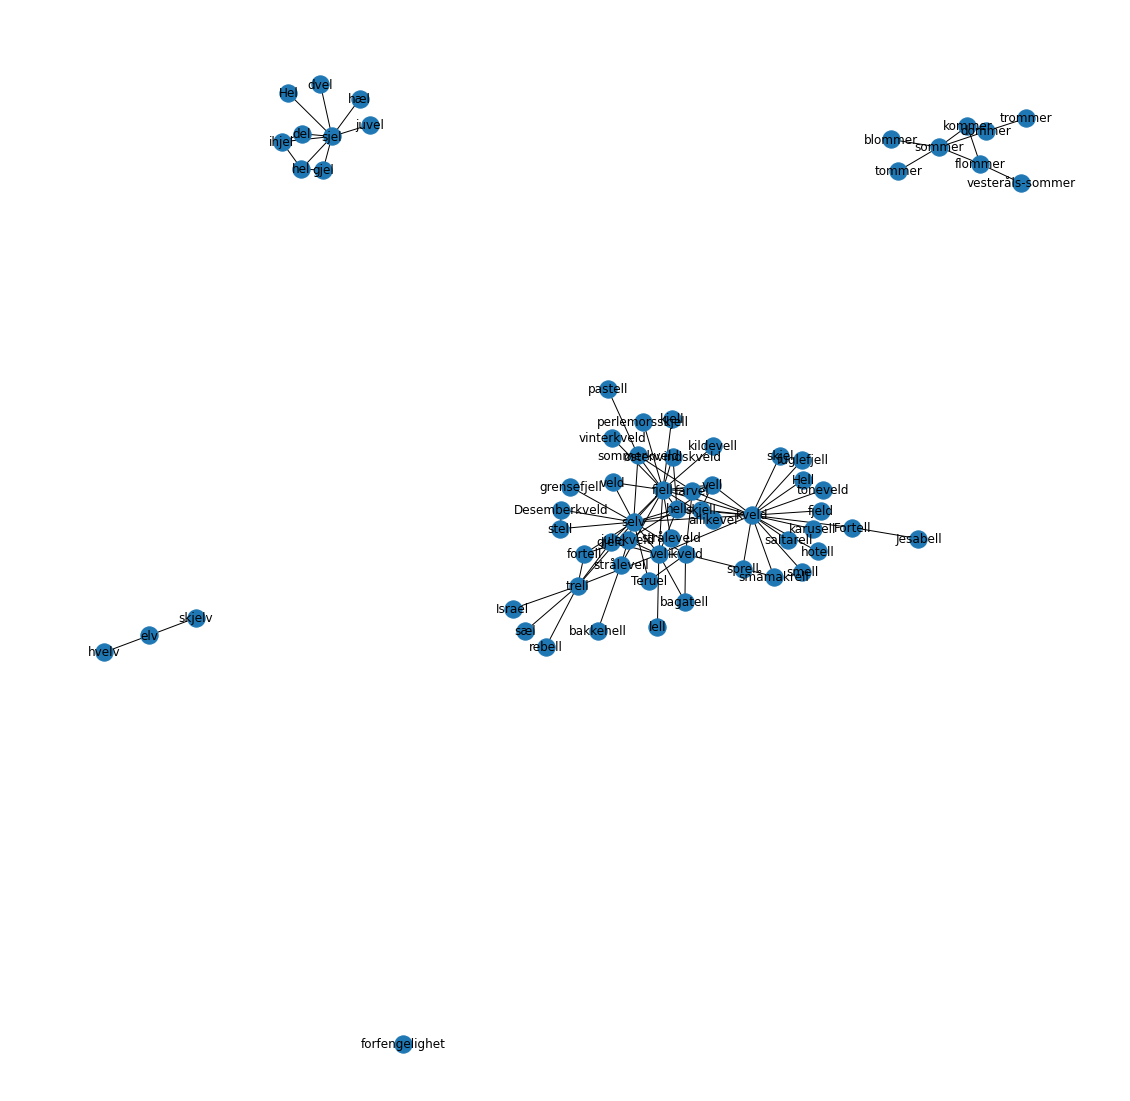

In [68]:
i = 5
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [
    # wrong
    ("forfengelighet", "selv"), ("del", "trommer"), ("sjel", "dommer"),
    
    #phonetically similar
    ("selv", "elv"), ("selv", "hvelv"), ("selv", "skjelv"), ("sjel", "vell"), 
]

for e in bad_edges: 
    g.remove_edge(*e)

g.add_edge("skjelv", "elv")

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 4 was separated into 3 components.
It originally had 92 vertices.
Now it has 90.



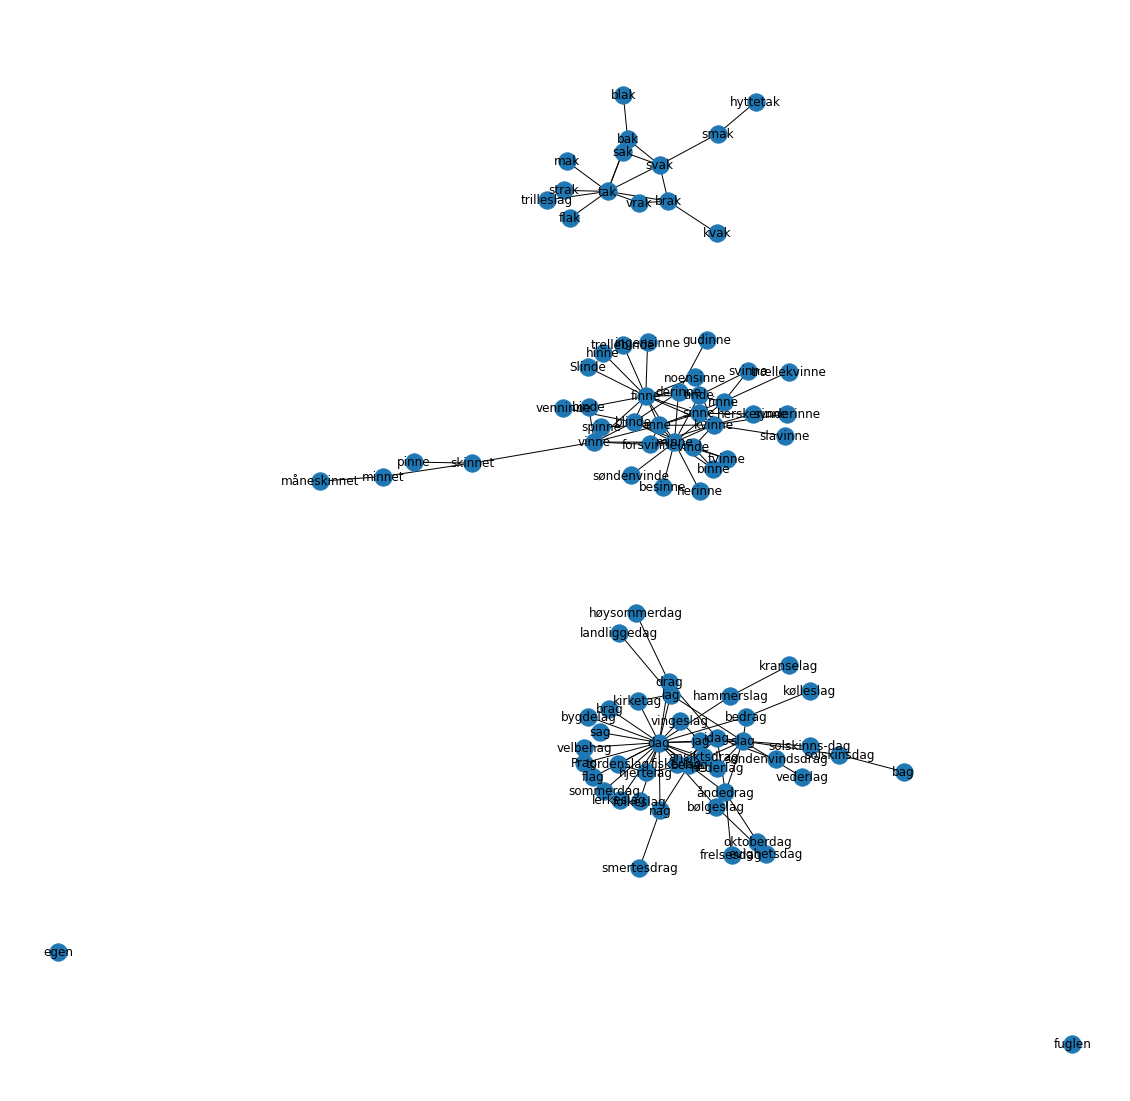

In [69]:
i = 4
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [
    # straight up wrong
    ("solskinsdag", "minne"), ("fuglen", "idag"), ("egen", "rinne"),
    
    # phonetically similart
    ("tak", "nag"), ("hyttetak", "dag")
]

for e in bad_edges:
    g.remove_edge(*e)
    
g.add_edge("hyttetak", "smak")

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 3 was separated into 8 components.
It originally had 144 vertices.
Now it has 144.



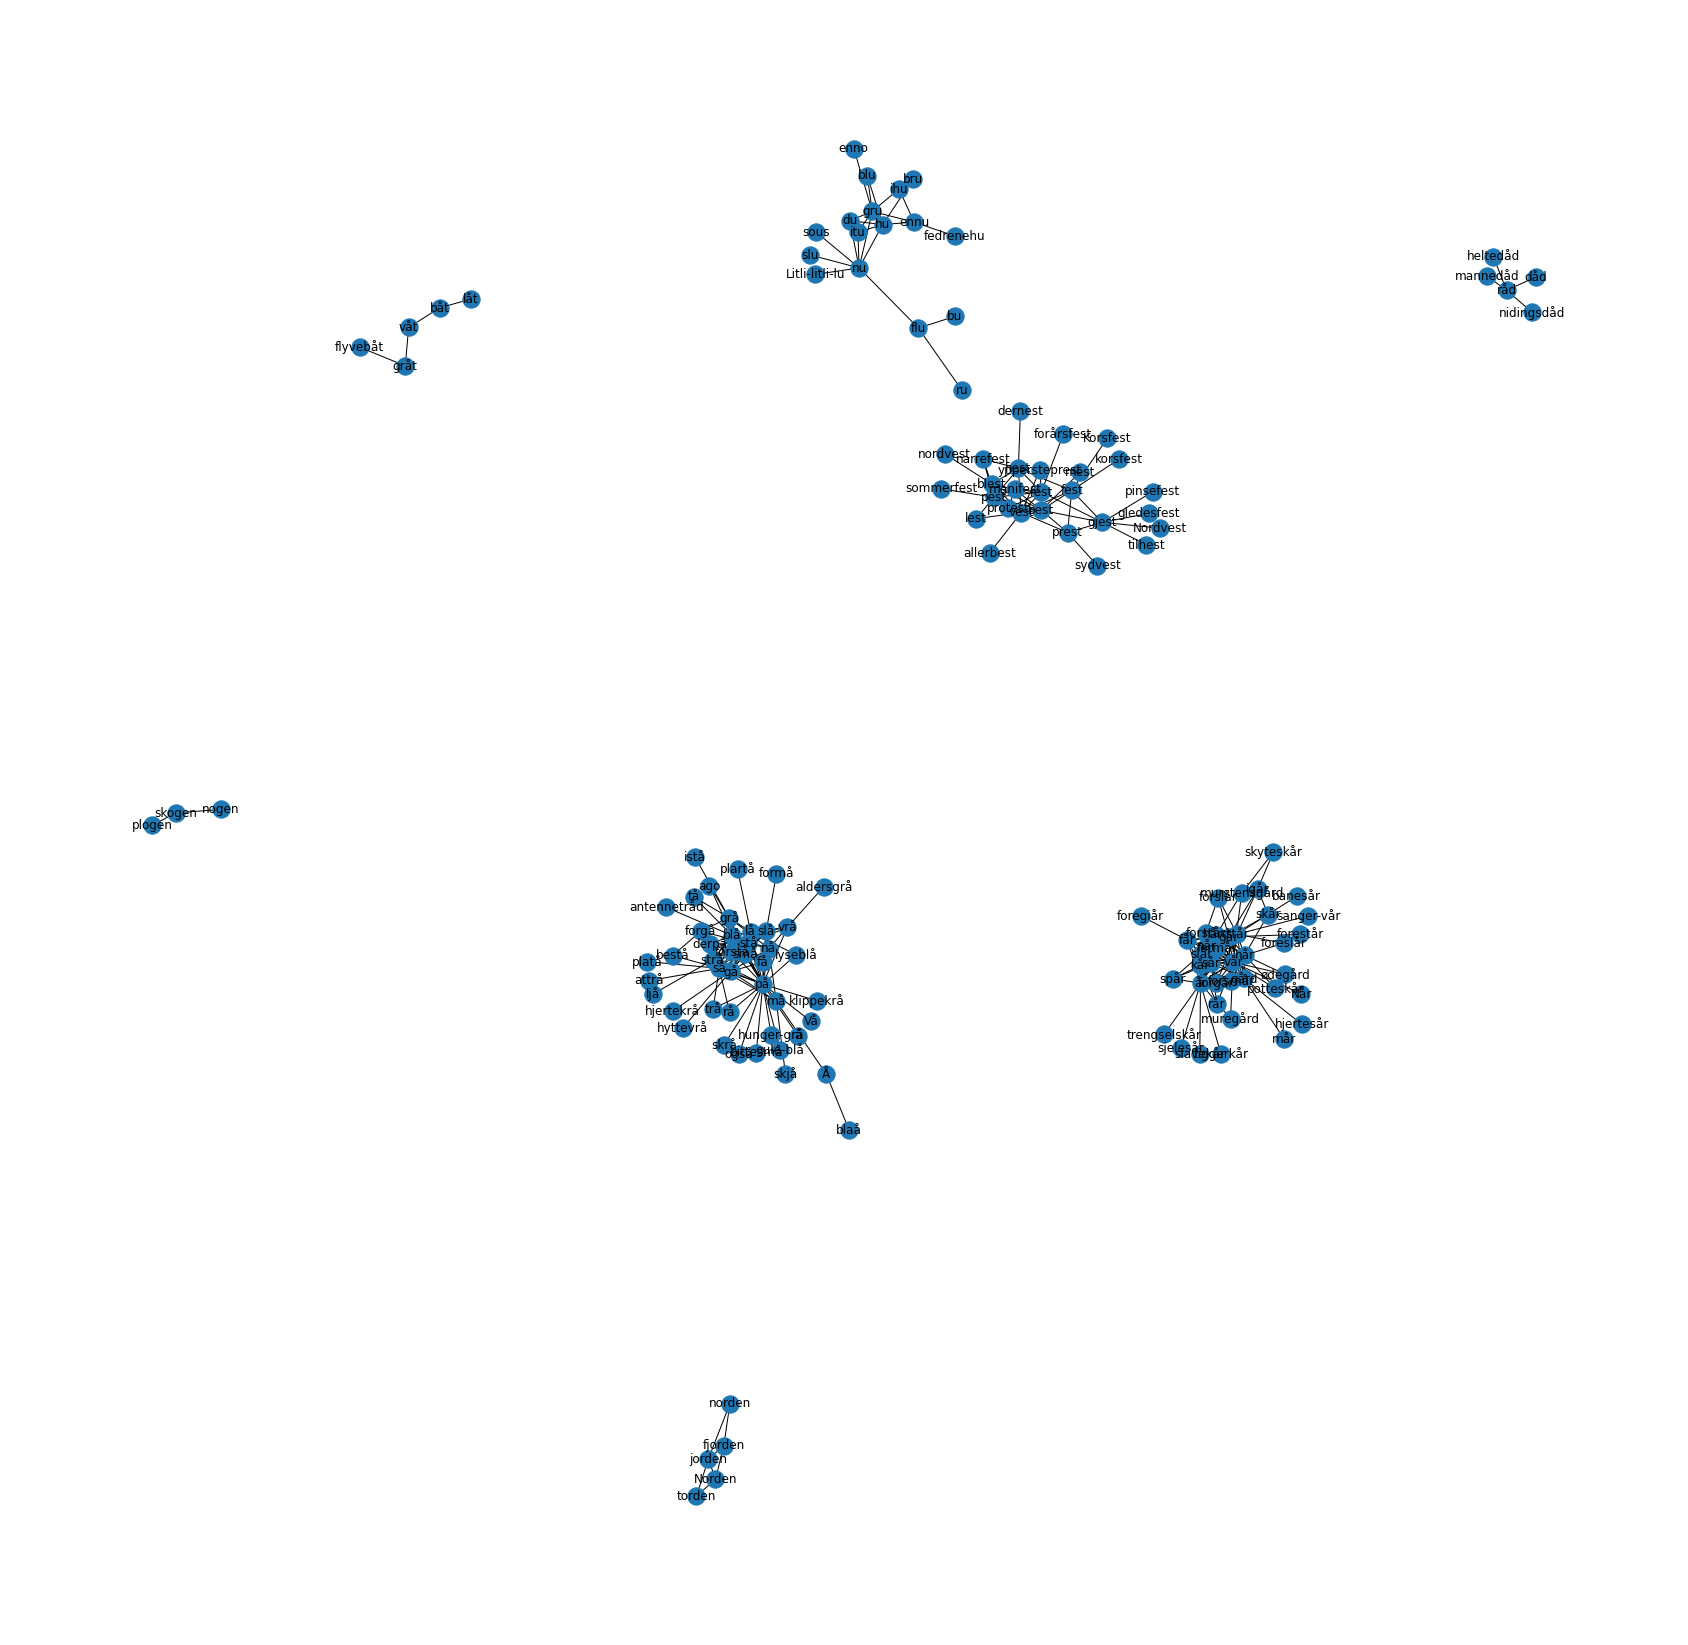

In [70]:
i = 3
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)

# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()

bad_edges = [
    # phonetically similar
    ("gråt", "dåd"), ("gråt", "nidingsdåd"),

    # nu _nå
    ("du", "nå"), ("hu", "nå"),
    
    # straight up wrong
    ("skogen", "sår"), ("plogen", "går"), ("fjorden", "skogen"),
    ("forstå", "fest"),("best", "forstå"), ("forgå", "når"),
]
                    # phonetic variation
for e in bad_edges + [("råd", "få")]:
    g.remove_edge(*e)

all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")
    
f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 2 was separated into 6 components.
It originally had 148 vertices.
Now it has 146.



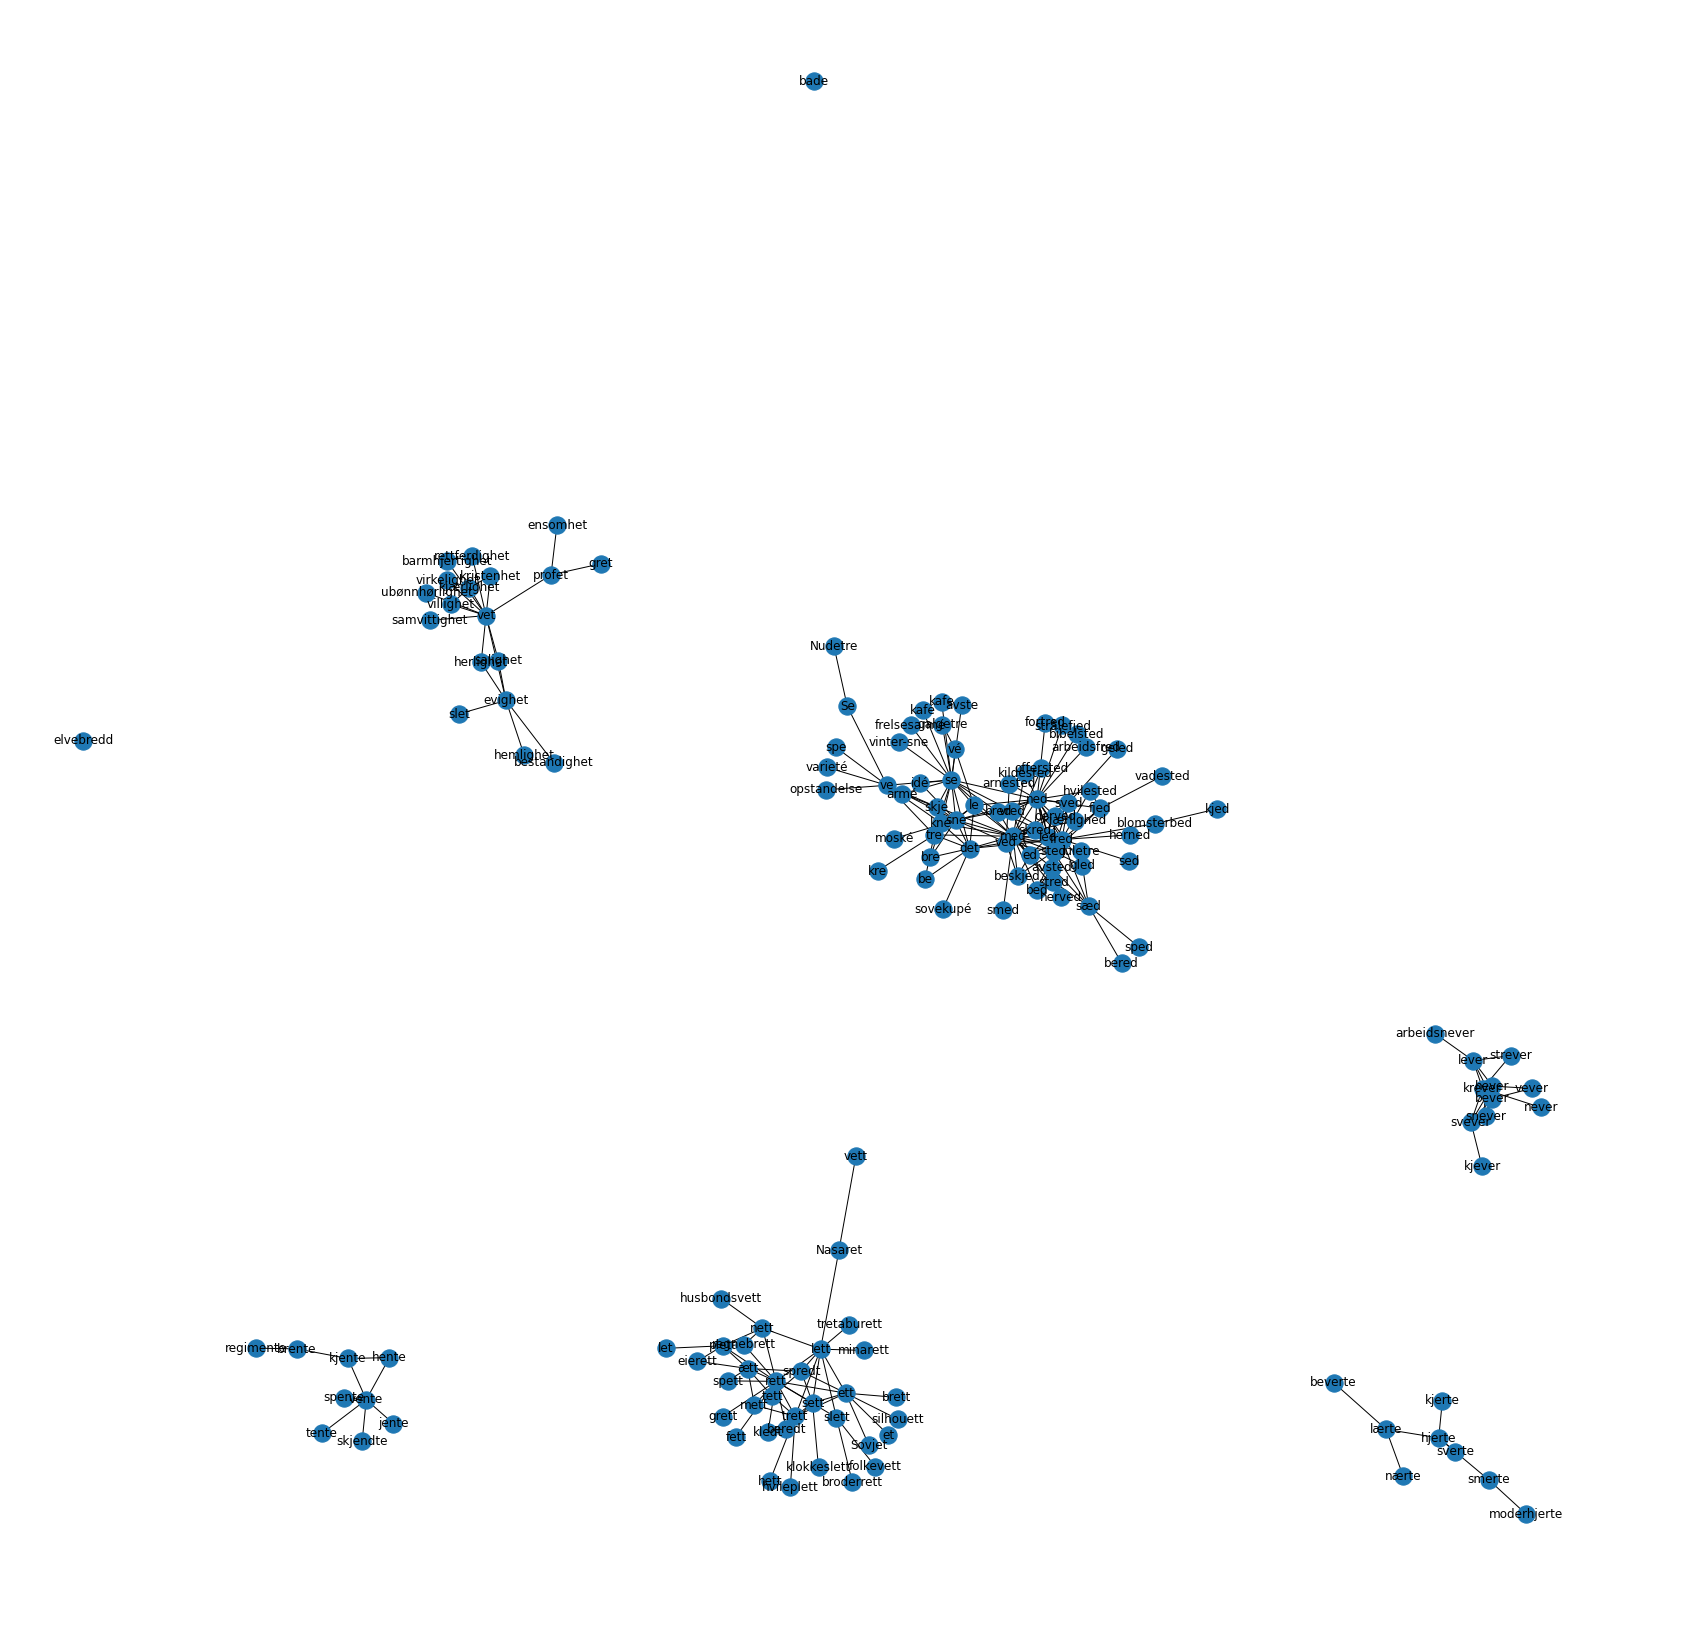

In [71]:
i = 2
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()


bad_edges = [
    # straight up wrong
    ("vred", "lever"), ("fred", "bever"), ("rett", "det"),
    
    #phonetically similar
    ("evighet", "ed"), ("vet", "ned"),
    ("ned", "kjærlighet"), ("ned", "gret"),
    ("elvebredd", "ned"), ("ensomhet", "med")
]

for e in bad_edges + [("tente", "det"), ("smerte", "det"), ("det", "bade")]:
    g.remove_edge(*e)
    
g.add_edge("gret", "profet")
g.add_edge("ensomhet", "profet")
    
all_bad_edges += bad_edges

words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 1 was separated into 10 components.
It originally had 189 vertices.
Now it has 188.



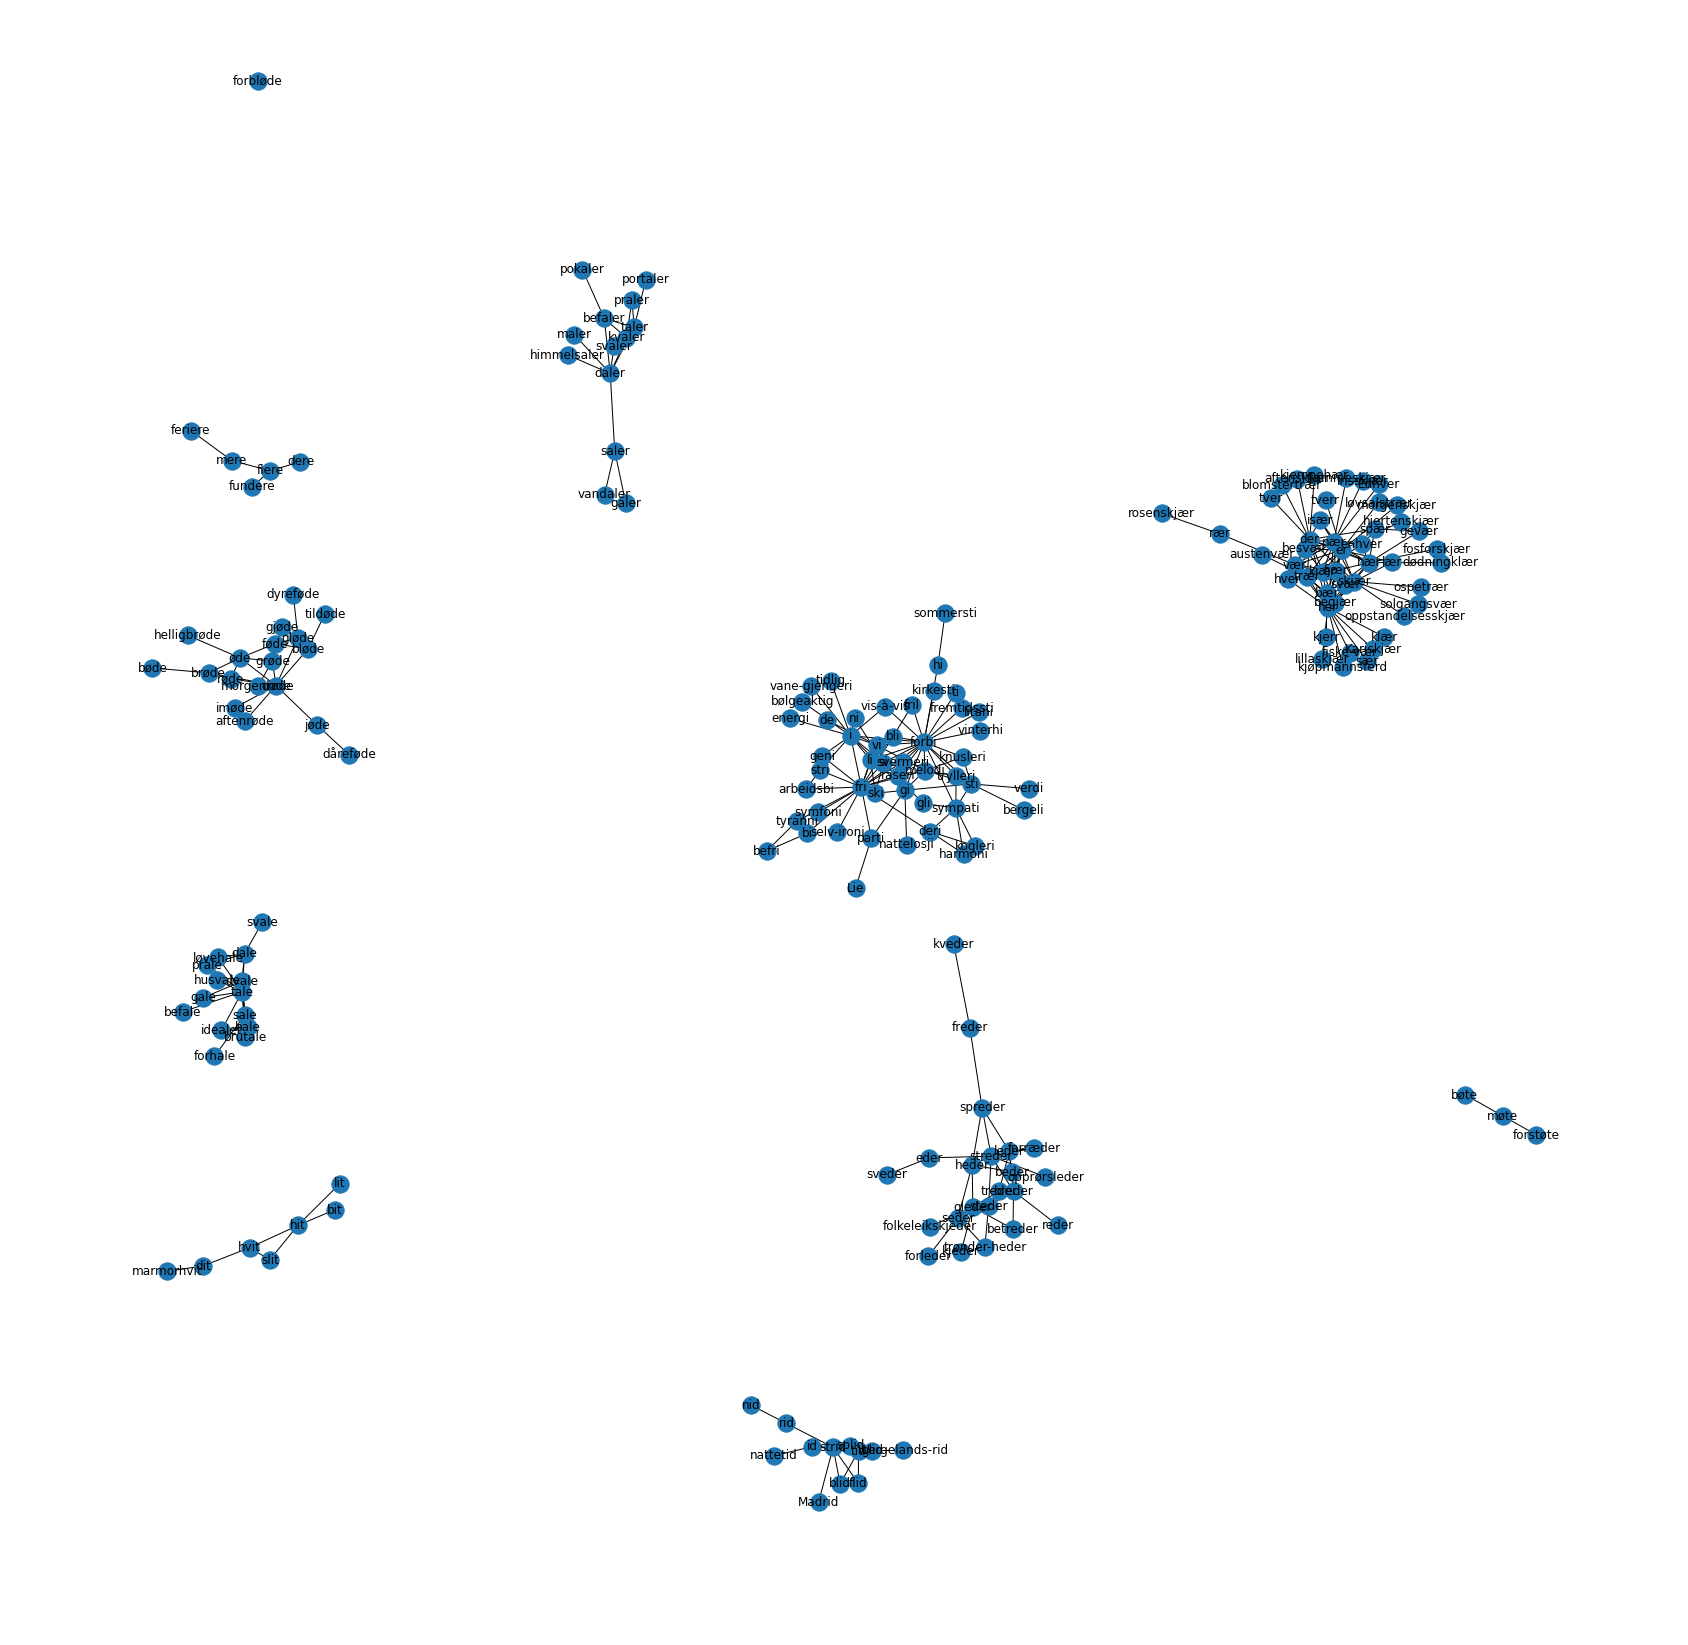

In [72]:
i = 1
g = graphs[i].copy()
size = len(g.nodes)

bad_edges = [
    # phonetically similar
    ("døde", "møte"), ("strid", "bit"), ("tid", "hit"), ("tid", "dit"), ("vi", "Wergelands-rid"), 
    
    # straight up wrong
    ("gløde", "strid"), ("daler", "tale"), ("heder", "der"), 
    ("dere", "svermeri"), ("dere", "heder"), ("dere", "kjær"), 
    ("dere", "sti"), ("dere", "opprørsleder"), ("tid", "tale"), ("forbløde", "tid")
   ]
                    # variations in pronuncitation
for e in bad_edges + [("vi", "tid")]:
    g.remove_edge(*e)

g.add_edge("opprørsleder", "streder")
g.add_edge("bit", "hit")
    
all_bad_edges += bad_edges
    
words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

Graph 0 was separated into 11 components.
It originally had 227 vertices.
Now it has 226.



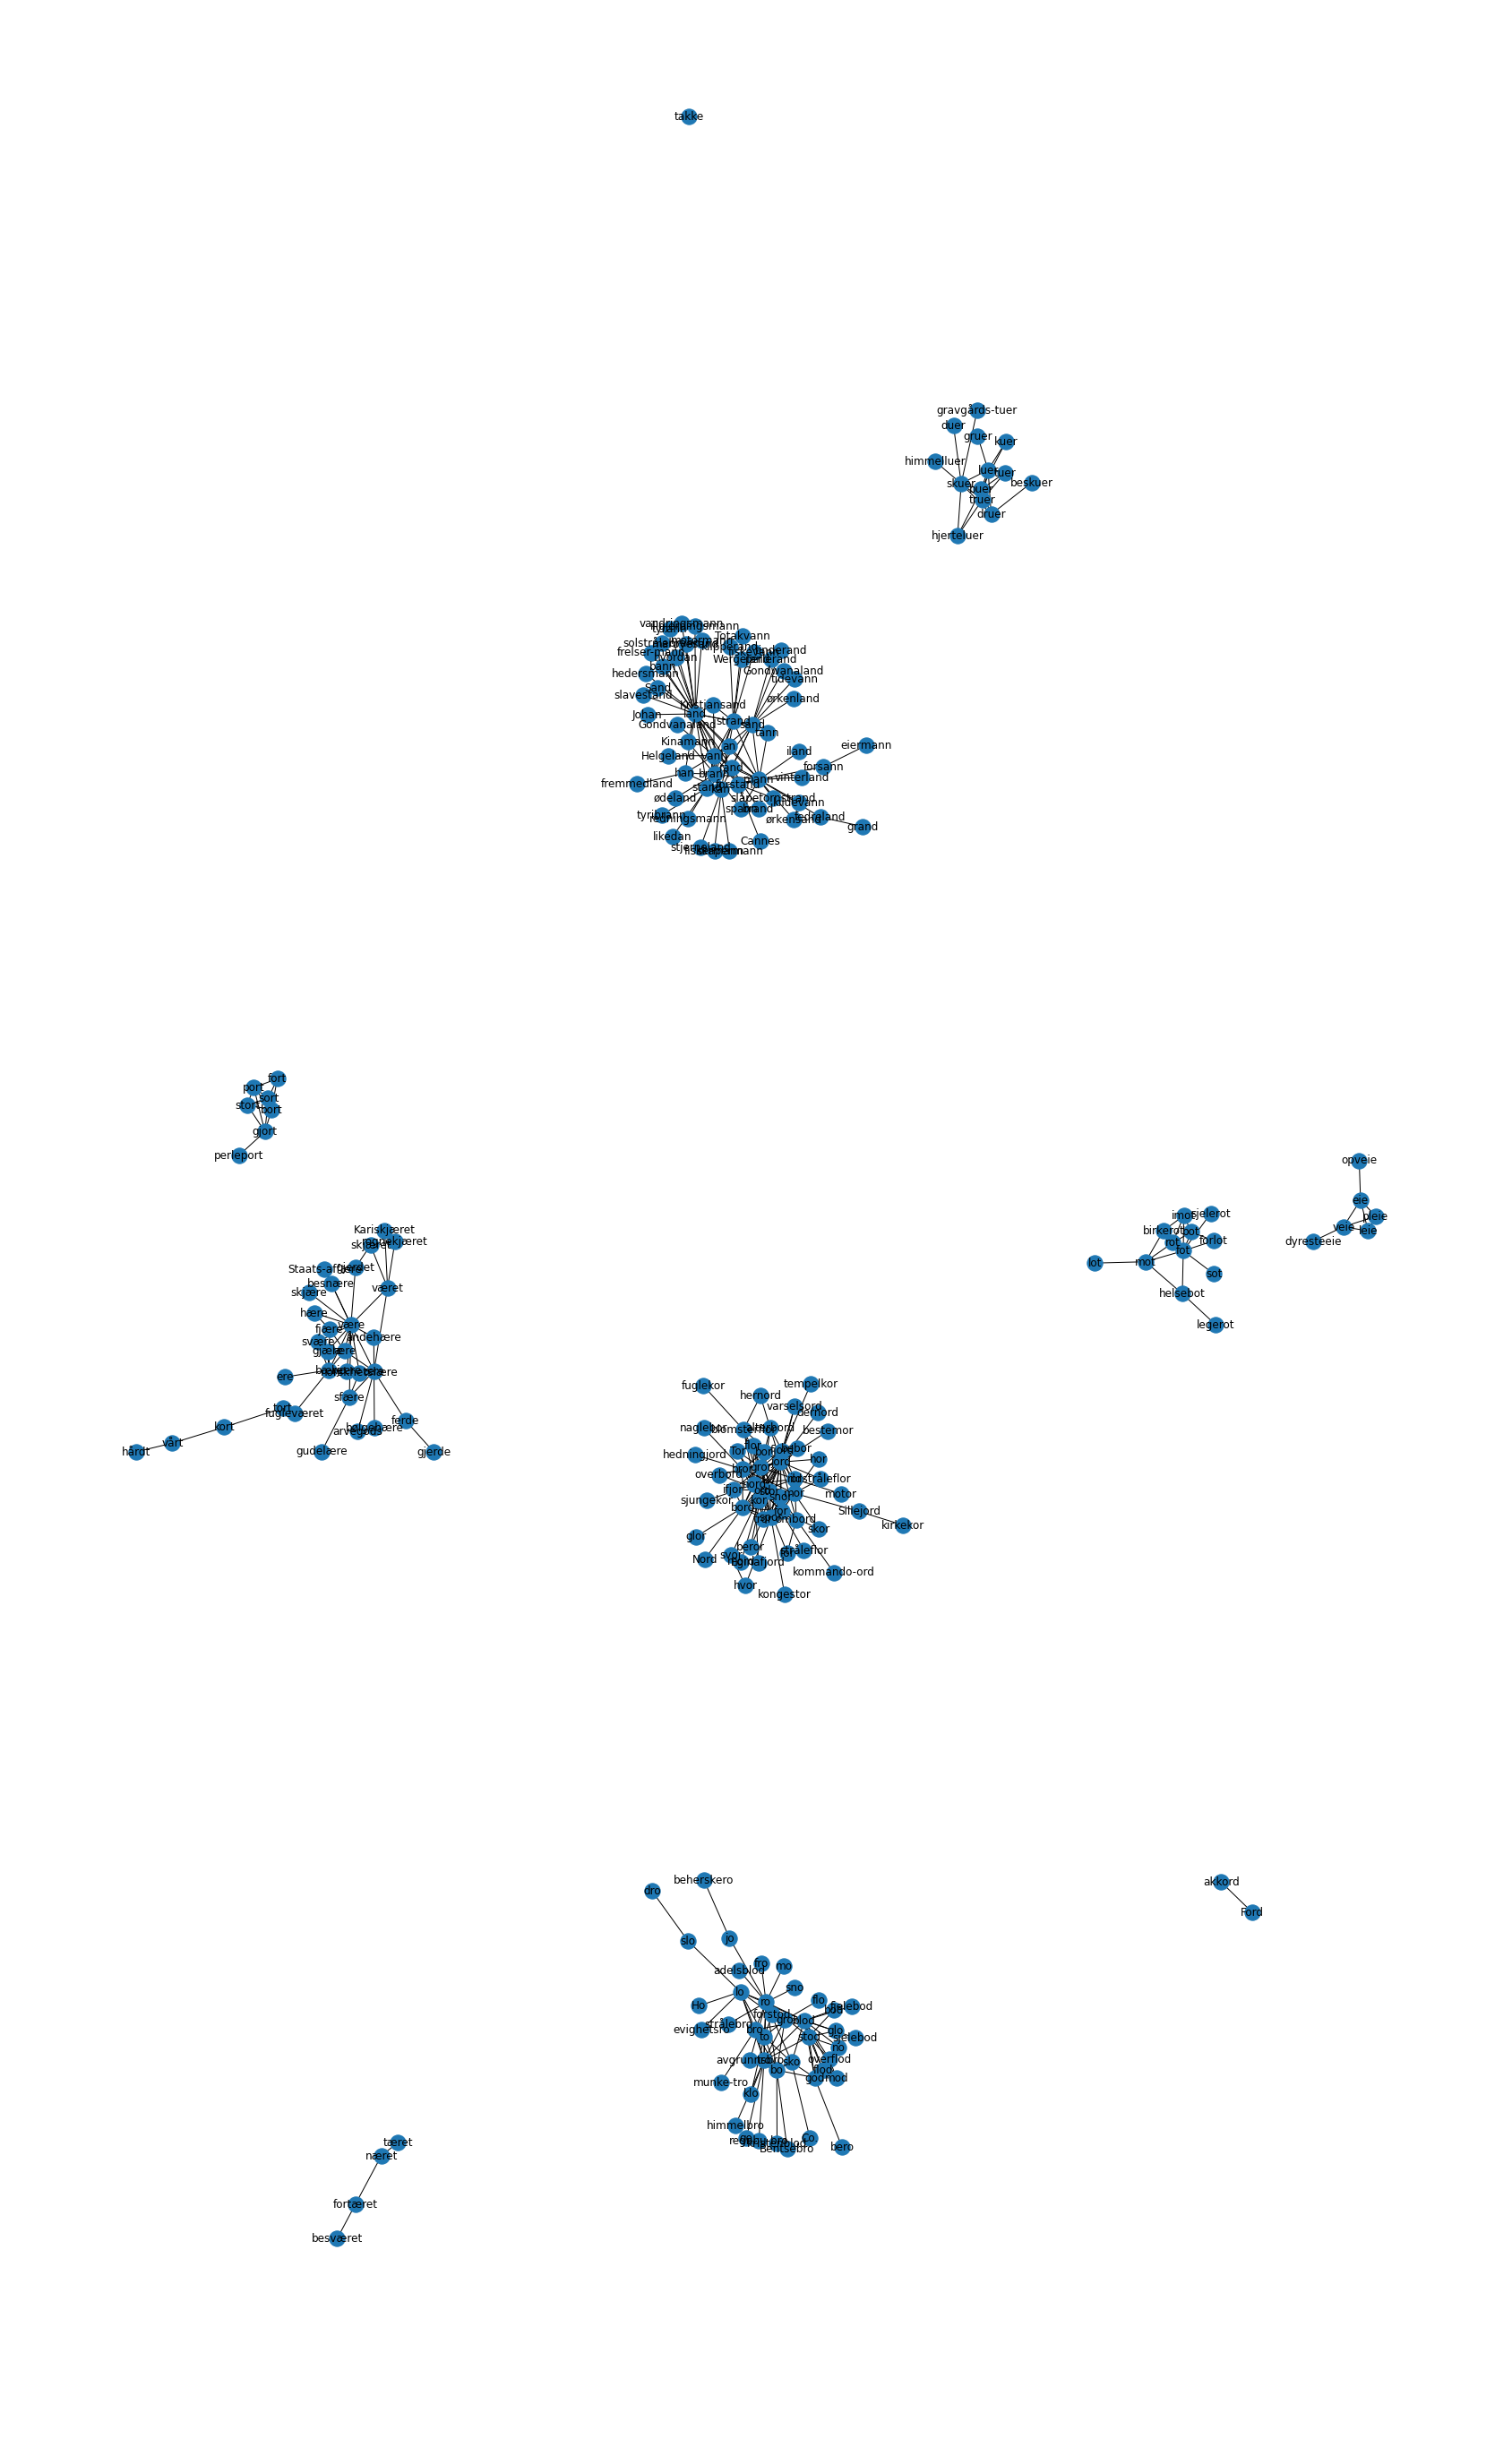

In [73]:
i = 0
g = graphs[i].copy()
size = len(g.nodes)

# f = get_fig(size)
# nx.draw(g, ax=f.add_subplot(111), with_labels=True)
# plt.show()
    
bad_edges = [
    # straight up wrong
    ("ære", "takke"),("land","bære"), ("strand", "bølgehære"), 
    ("imot", "lære"),("stort", "kan"), ("land", "stort"),
    ("skuer", "fot"),("land", "veie"), ("tro", "jord"), 

     #somewhat similar pronunciation (still wrong)
     ("lot", "blod"), ("fot", "stod"), ("fot", "blod"), ("bot", "flod"), 
     ("bort", "vårt"), ("bort", "kort"), ("stod", "legerot"),
]

                        #heteronym 'been' vs 'the weather'
for e in bad_edges + [("været", "besværet"), ("været", "fortæret"), ("akkord", "bord")]:
    g.remove_edge(*e)

g.add_edge("legerot", "helsebot")
g.add_edge("bølgehære", "ære")

    
all_bad_edges += bad_edges
    
words_, buckets_ = get_buckets_and_lost_words(g)
print(f"""Graph {i} was separated into {len(buckets_)} components.
It originally had {size} vertices.
Now it has {size - len(words_)}.
""")

f = get_fig(size)
nx.draw(g, ax=f.add_subplot(111), with_labels=True)
f.savefig(f"figs/manual_repair_{i}.png")

manual_buckets += list(nx.connected_components(g))

In [74]:
with open('pickles/bad_edges.pickle','wb') as f:
    pickle.dump(all_bad_edges, f)

In [75]:
manual_buckets = [list(e) for e in manual_buckets if len(e) > 2]

In [76]:
tot_words = sum(len(bucket) for bucket in manual_buckets)
print(f"""For the {len(manual_buckets)} more buckets:
Total words: {tot_words}
% of vocab: {tot_words/len(vocab)*100}
Avg length: {tot_words/len(manual_buckets)}
""")

For the 91 more buckets:
Total words: 1492
% of vocab: 23.72019077901431
Avg length: 16.395604395604394



In [77]:
with open('pickles/manual_repair_buckets.pickle','wb') as f:
    pickle.dump(manual_buckets, f)

In [78]:
m_pairs = set()

for bucket in manual_buckets:
    c = list(itertools.combinations(bucket, 2))
    if c:
        rem = get_mirrored_dupes(c)
        c = set(c) - rem
        m_pairs.update(c)
len(m_pairs)

20183

In [79]:
m_pairs

{('Å', 'skrå'),
 ('med', 'ned'),
 ('nattelosji', 'bli'),
 ('spredt', 'ett'),
 ('tyribrann', 'Wergeland'),
 ('gjenoppta', 'derifra'),
 ('stor', 'hernord'),
 ('fram', 'dyreham'),
 ('nordlys-prakt', 'strakt'),
 ('flor', 'kirkekor'),
 ('let', 'lett'),
 ('sne', 'herned'),
 ('bølgegrav', 'stav'),
 ('kjed', 'spe'),
 ('fril', 'hi'),
 ('naglebor', 'stråleflor'),
 ('hedningjord', 'bestemor'),
 ('flak', 'vrak'),
 ('fril', 'befri'),
 ('få', 'også'),
 ('Sand', 'tyribrann'),
 ('da', 'hurra'),
 ('kjød', 'forbrød'),
 ('Teruel', 'trell'),
 ('lell', 'bakkehell'),
 ('tid', 'rid'),
 ('helstøvle-føre', 'snøre'),
 ('pinsefest', 'dernest'),
 ('blomstermunne', 'sunde'),
 ('grå', 'også'),
 ('herlighet', 'ensomhet'),
 ('motor', 'fuglekor'),
 ('forgår', 'kår'),
 ('grett', 'regnebrett'),
 ('være', 'Staats-affære'),
 ('frydeskrik', 'fugleskrik'),
 ('ti', 'sympati'),
 ('være', 'besnære'),
 ('ansiktsdrag', 'oktoberdag'),
 ('sæl', 'fjell'),
 ('løvsalstrær', 'oppstandelsesskjær'),
 ('skapermann', 'illgjerningsmann'),


In [80]:
pairs_

{('stillehavspassat', 'satt'),
 ('stjerneblått', 'blott'),
 ('manne-fall', 'tempelhall'),
 ('store', 'roret'),
 ('fare', 'mare'),
 ('vin', 'sin'),
 ('ring', 'Ting'),
 ('tynt', 'skillemynt'),
 ('skinn', 'grind'),
 ('kvede', 'brede'),
 ('vinge', 'springe'),
 ('liljebånd', 'ånd'),
 ('godt', 'gått'),
 ('trykker', 'nykker'),
 ('tåkeluft', 'duft'),
 ('herskerstol', 'Hol'),
 ('morgen-røden', 'grøden'),
 ('vold', 'avindsskjold'),
 ('kingelvevet', 'bevet'),
 ('teller', 'kvelder'),
 ('aftenrøden', 'hungersnøden'),
 ('borg', 'kongeborg'),
 ('traff', 'blaff'),
 ('året', 'dåret'),
 ('solgangsild', 'till'),
 ('drømmen', 'himmeldrømmen'),
 ('sende', 'overende'),
 ('ditinn', 'marsaftenvind'),
 ('dravat', 'soldat'),
 ('politikk', 'fabrikk'),
 ('sunn', 'stund'),
 ('flyr', 'knyr'),
 ('vestenvind', 'marsaftenvind'),
 ('flammer', 'prammer'),
 ('lytter', 'hytter'),
 ('hedningeby', 'ly'),
 ('kinner', 'pinner'),
 ('profitt', 'mareritt'),
 ('randen', 'stranden'),
 ('bevare', 'broderskare'),
 ('hjernespinn', 's

In [81]:
pairs2 = pairs_.copy()
pairs2.update(m_pairs)
len(pairs2)

38599

In [82]:
new_pairs = m_pairs - orig_pairs 

In [83]:
v = [w for b in manual_buckets for w in b]
print(f"""
With the buckets we got from manual graph clustering we got {len(manual_buckets)} new buckets
Average size: {len(v)/len(manual_buckets)}
{len(v)} words out of {len(vocab)} total
We lost {tot_len-len(v)} vertices

All combinations of the buckets give us {len(m_pairs)} rhyme pairs.
Of these, {len(orig_pairs.intersection(m_pairs))} already existed in the pairs data set.
We increased the pair set by {len(new_pairs)}.

However, the original pairs data set contain bad edges.
We add the {len(pairs_)} good_buckets pairs and {len(m_pairs)} manual_buckets pairs together for a new pair dataset.
The total length is {len(pairs2)}
""")



With the buckets we got from manual graph clustering we got 91 new buckets
Average size: 16.395604395604394
1492 words out of 6290 total
We lost 16 vertices

All combinations of the buckets give us 20183 rhyme pairs.
Of these, 1226 already existed in the pairs data set.
We increased the pair set by 18957.

However, the original pairs data set contain bad edges.
We add the 18416 good_buckets pairs and 20183 manual_buckets pairs together for a new pair dataset.
The total length is 38599



In [92]:
words_a, words_b = zip(*pairs2)
pair_df = pd.DataFrame({"word_a" : words_a, "word_b": words_b, "rhyme": [1]*len(pairs2)})
pair_df.to_csv("tsvs/manual_repair_plus_good_buckets_pairs.tsv", sep="\t", index=False)

In [93]:
pair_df

,word_a,word_b,rhyme
0,Å,skrå,1
1,stillehavspassat,satt,1
2,stjerneblått,blott,1
3,med,ned,1
4,nattelosji,bli,1
...,...,...,...
38594,forpakter,dårefakter,1
38595,finner,hinder,1
38596,brøden,evighetsrøden,1
38597,hist,kvist,1


In [94]:
v = set(list(pair_df.word_a)+list(pair_df.word_b))
len(v)

6272

In [85]:
len(all_bad_edges)

106